# Calibration on the flooding model : propagation of the prior

In this example, we propagate the gaussian prior distribution on the flooding model. The goal of this step is to check that the parameters of the prior distribution are compatible with the observations.  

A condition is required so that $Z_v$ and $Z_m$ are compatible with the flooding model. Otherwise, it may happen that $Z_v\geq Z_m$, so that the output of the model cannot be computed.

There are several solutions for that problem.

* The marginals of the prior distribution can be chosen so that the probability $P(Z_v\geq Z_m)$ is mathematically close to zero (and practically equal to zero).
* A dependency can be added between $Z_v$ and $Z_m$ so that $Z_v\geq Z_m$. This can be done through the covariance matrix of the prior distribution. However, given that a gaussian covariance must be chosen, the probability $P(Z_v\geq Z_m)$ can be made close to zero, but not exactly zero. 

In this example, the marginals of the gaussian prior distribution are chosen so that the probability $P(Z_v\geq Z_m)$ is very close to zero, but the covariance matrix is kept diagonal (so that the copula is independent).

In [1]:
import openturns as ot
from math import sqrt

## Definition of the model

In [2]:
observedSample = ot.Sample_ImportFromCSVFile("calibration-flooding-observations.csv")
nbobs = observedSample.getSize()
Qobs = observedSample[:,0]
Hobs = observedSample[:,1]
nbobs

100

In [3]:
Hobs.setDescription(["Height (m)"])

In [4]:
def functionFloodingModel(X):
    Q, K_s, Z_v, Z_m = X
    L = 5.0e3
    B = 300.0
    alpha = (Z_m - Z_v)/L
    H = (Q/(K_s*B*sqrt(alpha)))**(3.0/5.0)
    return [H]

In [5]:
modelPyFunc = ot.PythonFunction(4, 1, functionFloodingModel)
modelPyFunc.setDescription(["Q", "Ks", "Zv", "Zm","H"])

In [6]:
KsInitial = 25.
ZvInitial = 47.
ZmInitial = 53.
thetaB = ot.Point([KsInitial,ZvInitial,ZmInitial])

In [7]:
calibratedIndices = [1,2,3]
mycf = ot.ParametricFunction(modelPyFunc, calibratedIndices, thetaB)
mycf(Qobs)[0:5]

class=Sample name=Unnamed implementation=class=SampleImplementation name=Unnamed size=5 dimension=1 description=[H] data=[[2.25519],[2.99861],[2.81647],[3.49886],[2.49084]]

## Propagation of the prior distribution

In [8]:
sigmaKs = 7.
sigmaZv = 1.
sigmaZm = 1.
sigmaTheta = [sigmaKs,sigmaZv,sigmaZm]

In [9]:
Sigma = ot.CovarianceMatrix(3)
Sigma[0,0] = sigmaKs
Sigma[1,1] = sigmaZv
Sigma[2,2] = sigmaZm
Sigma

class=CovarianceMatrix dimension=3 implementation=class=MatrixImplementation name=Unnamed rows=3 columns=3 values=[7,0,0,0,1,0,0,0,1]

In [10]:
prior = ot.Normal(thetaB,Sigma)

In [11]:
n = 100

In [12]:
theta = prior.getSample(n)

In [13]:
Hpredicted = ot.Sample(nbobs,n)
for j in range(n):
    mycf.setParameter(theta[j])
    Hpredicted[:,j] = mycf(Qobs)

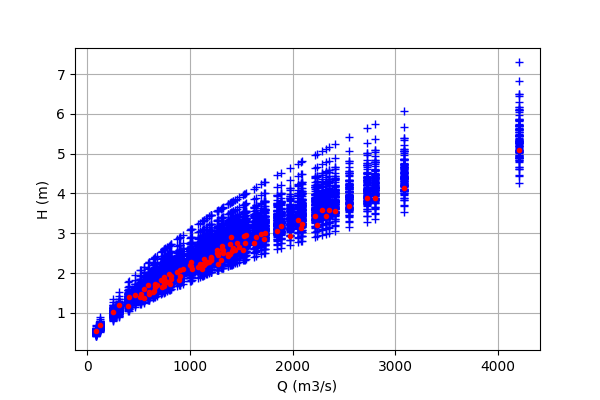

In [15]:
graph = ot.Graph("","Q (m3/s)","H (m)",True)
# Predictions
for i in range(nbobs):
    Qobs_i = ot.Point(n)
    for j in range(n):
        Qobs_i[j] = Qobs[i,0]
    cloud = ot.Cloud(Qobs_i,Hpredicted[i,:])
    graph.add(cloud)
# Observations
cloud = ot.Cloud(Qobs,Hobs)
cloud.setColor("red")
cloud.setPointStyle("bullet")
graph.add(cloud)
graph

Since the predictions (the blue crosses) are well within the observations (the red bullets), the model can be calibrated.